# Collaborative Filtering

**By Li-Yen Hsu (11/10/2017)**
<br><br>
The goal of this project is to predict the ratings that would be given by each consumer for the restaurants he/she has not rated. A list of restaurants with the highest predicted ratings can then be recommended to each consumer. Because the restaurant ratings are numerical, predicting their values can be treated as a regression problem. Using classification techniques is also reasonable since the ratings are 0, 1 or 2 in this dataset. However, a multi-class classification will likely predict too many ties and therefore prevent us from generating a top-n list of recommendations for a consumer. Rather than predicting the exact values of ratings that a consumer would give to certain restaurants, what is more important for a recommender system is predicting the ranking of these restaurants for the consumer. Thus, I will attempt to predict continuous values in this notebook.
<br><br>
I will use matrix factorization-based algorithms for rating prediction. The fundamental concepts are that each item is characterized by a vector of features; each consumer preference is described by a vector of weights which has the same dimension as the item features; and the predicted rating of a item-consumer pair equals the inner product of the two vectors. The mathematics is therefore equivalent to a simple linear regression. For a content-based approach, the features are already determined based on the product information, leaving the weights to be optimized. For collaborative filtering, both the features and weights are the parameters to be optimized. I will use the latter in this notebook. Instead of using an existing library for recommender systems, I will implement the cost functions of the problem and perform optimization using "minimize()" from the SciPy package. But I will also run a [SVD model](http://sifter.org/simon/journal/20061211.html) using [Surprise](http://surpriselib.com/) at the end and compare its performance with mine.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Since I will use collaborative filtering approaches, only the csv file 
# for the ratings is needed
rating = pd.read_csv('data/rating_final.csv')

## Data Preprocessing
Let's first look at the data frame.

In [2]:
rating.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In [3]:
n_user = len(rating.userID.unique())
n_res = len(rating.placeID.unique())
n_rating = len(rating)

print("There are {} unique userID's.".format(n_user))
print("There are {} unique placeID's.".format(n_res))
print("There are {} * 3 ratings.".format(n_rating))

There are 138 unique userID's.
There are 130 unique placeID's.
There are 1161 * 3 ratings.


In [4]:
rating.iloc[:,2:].describe()

,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000
mean,1.199828,1.215332,1.090439
std,0.773282,0.792294,0.790844
min,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000
max,2.000000,2.000000,2.000000


I will now create three matrices (**Y_overall**, **Y_food**, and **Y_service**) for the three types of rating, each of which will have a shape of (130, 138). A restaurant-user pair without a rating will be recorded as -1 (to be different from 0, the lowest rating).

In [5]:
placeID = np.sort(rating.placeID.unique()) # All the placeID's
userID = np.sort(rating.userID.unique())   # All the userID's

Y_overall = pd.DataFrame(np.zeros((n_res,n_user))-1, columns=userID, index=placeID)
Y_food = Y_overall.copy()
Y_service = Y_overall.copy() 

for p, u, o, f, s in zip(rating.placeID, rating.userID, rating.rating, rating.food_rating, 
                         rating.service_rating):
    Y_overall.loc[p,u] = o
    Y_food.loc[p,u] = f
    Y_service.loc[p,u] = s

Y_overall = Y_overall.values
Y_food = Y_food.values
Y_service = Y_service.values

Now I create another matrix **R** with the same shape, which tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.

In [6]:
R = np.zeros(Y_overall.shape)
R[Y_overall >= 0] = 1

## Train/Test Split

Before we implement the models, let's split the existing ratings into training/test sets using a 70/30 split. Similar to the matrix **R**, I will create another two matrices, **R_train** and **R_test**, for the training and test sets, respectively. Note that I will split the ratings, not the restaurants or users. Specifically, 30% of the ratings from each user will be separated for testing. In addition, I will ensure that every restaurant and every consumer receives/gives some ratings in the training set. This constraint makes sure that the characteristic of every restaurant and consumer is learned. 
<br><br>
Ideally, it's better to split the data into training/validation/test sets, where the validation set is used to tune the model, and the test set is used to check whether the chosen model also performs well on unseen data. However, the number of existing ratings in this dataset is really small. If we used, say, a 60/20/20 split, most of the users in either the validation or test set would have less than three true ratings, which is not very useful for evaluating the predicted restaurant ranking.

In [7]:
# 30% of the existing ratings will be used as the test set, so during 
# the training, they will be flagged. 
#
# The minimum number of ratings from a user = 3. In such a case, it 
# will be a 2/1 split.

random.seed(99)
cond = True

while cond:

    R_train = R.copy()

    # loop over each user
    for i in range(R_train.shape[1]):
        # the restaurants that are rated
        index = list( np.where(R_train[:,i] == 1)[0] )  
        # randomly select about 30% of them to be flagged
        flag = int(round(len(index)*0.3))
        index_flag = random.sample(index,flag)
        R_train[index_flag,i] = 0  
    
    # make sure in the traning set, each restaurant also has at least 
    # 2 ratings
    if np.sum(R_train,axis=1).min() > 1: 
        cond = False

# the rest will be the test set        
R_test = R - R_train

# Now "R_train" contains 810 ones and "R_test" contains 351 ones ("R" contains 1161 ones)
print(R_train.sum(), R_test.sum())

(810.0, 351.0)


## Evaluation Metrics ##
I will use two evaluation metrics to quantify the model performances. The first one is root-mean-square error (RMSE), which is very standard for regression problems because it tells you how close your predictions are to the labels. However, for recommender systems, the most important thing is the ranking of the items, and RMSE sometimes doesn't work well for this purpose. For example, a perfectly ranked prediction can have a terrible RMSE by predicting the ratings on the wrong scale.
<br>
<br>
Thus, the second metric I will use is **Fraction of Concordant Pairs (FCP)**. Please refer to Section 5.2 of this [paper](http://www.ijcai.org/Proceedings/13/Papers/449.pdf). The concept is the following. Suppose a user has rated n products, then there are n*(n-1)/2 unique pairs of ratings. If product A receives a higher rating than product B from a user and the model predicts the same, A and B are a concordant pair, otherwise a discordant pair. FCP is simply the fraction of concordant pairs among all the pairs (sum over all users). Note that because the ratings are discrete integers, many rating pairs would actually be ties. In such cases, they would not be included in the calculation of FCP.

In [8]:
def RMSE(Y,Y_pred,R):
    
    return np.sqrt(mean_squared_error(Y[R  == 1], Y_pred[R == 1]))


def FCP(Y,Y_pred,R,verbose=True):
    
    # list of true ratings from each user (we only select users with at least two ratings)
    Y_fcp = []  
    Y_pred_fcp = [] # list of predicted ratings from each user 
    n_user = R.shape[1]
    
    for i in range(n_user):
        
        cond = (R.sum(axis=0) >= 2)[i] # there should be at least two ratings from a user
        index = np.where( R[:,i] == 1)[0] # the indices (restaurants) with ratings
    
        if cond:
            
            Y_fcp.append( (Y*R)[:,i][index] )
            Y_pred_fcp.append( (Y_pred*R)[:,i][index] )

        
    n_fcp = len(Y_fcp) # number of users with at least two ratings
    TP = 0. # Total number of pairs
    DP = 0. # number of discordant pairs
    CP = 0. # number of concordant pairs (excluding ties)
    
    for i in range(n_fcp):
        
        num_Y = len(Y_fcp[i])   # number of ratings from a user
        TP += num_Y*(num_Y-1)/2 # number of rating pairs = n*(n+1)/2 

        greater = np.array([])
        greater_pred = np.array([])

        # this loop is to go over all the rating pairs
        for j in range(num_Y-1):
            
            not_equal = Y_fcp[i][j] != Y_fcp[i][j+1:]
            greater = Y_fcp[i][j] > Y_fcp[i][j+1:]
            greater_pred = Y_pred_fcp[i][j] > Y_pred_fcp[i][j+1:]

            # filter the ones that are not ties
            greater = greater[not_equal]
            greater_pred = greater_pred[not_equal]

            DP += (greater != greater_pred).sum()
            CP += (greater == greater_pred).sum()
            
    if verbose:        
        print("Total number of rating pairs: {}".format(int(TP)))
        print("Total number of discordant pairs: {}".format(int(DP)))
        print("Total number of concordant pairs: {}".format(int(CP)))
        print("Total number of ties: {}".format(int(TP-DP-CP)))
        print("FCP: {}".format(CP/(CP+DP)))
    
    return CP/(CP+DP)

## Benchmark Model ##
Now we can try building our models. I will only predict the overall ratings in this notebook, as the procedures for the other two ratings are exactly the same anyway. First, I will implement a benchmark model which simply predicts the average of the ratings that a restaurant already received. We can later compare other models with this benchmark to see if they are doing better than just using average ratings.

In [9]:
def GetMean(Y,R):

    Y = Y*R
    mean =  (np.sum(Y, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    return mean

In [10]:
Y = Y_overall 
Y_mean = GetMean(Y,R_train) # get the average ratings based on the training set
Y_pred = np.zeros(Y.shape) + Y_mean # prediction 

# RMSE
print("RMSE of the training set: {}".format(RMSE(Y,Y_pred,R_train)))
print("RMSE of the test set: {}".format(RMSE(Y,Y_pred,R_test)))

RMSE of the training set: 0.694777439953
RMSE of the test set: 0.82419115992


In [11]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Test Set:")
FCP(Y,Y_pred,R_test)

Training Set:
Total number of rating pairs: 2380
Total number of discordant pairs: 327
Total number of concordant pairs: 728
Total number of ties: 1325
FCP: 0.690047393365


Test Set:
Total number of rating pairs: 339
Total number of discordant pairs: 57
Total number of concordant pairs: 76
Total number of ties: 206
FCP: 0.571428571429


0.5714285714285714

In [12]:
# A plotter to make boxplot
def MakeBoxplot(Y_pred, Y_true, R, title):
    
    data1 = Y_pred[R == 1][Y_true[R == 1] == 0]
    data2 = Y_pred[R == 1][Y_true[R == 1] == 1]
    data3 = Y_pred[R == 1][Y_true[R == 1] == 2]
    data = [data1,data2,data3]

    fig = plt.figure()
    plt.boxplot(data)
    plt.xticks([1, 2, 3],[0,1,2])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

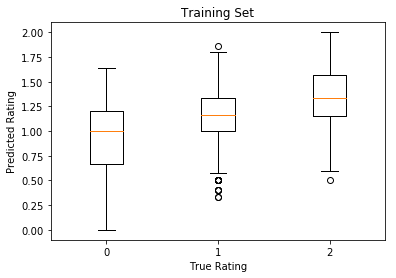

In [13]:
MakeBoxplot(Y_pred, Y, R_train, 'Training Set')

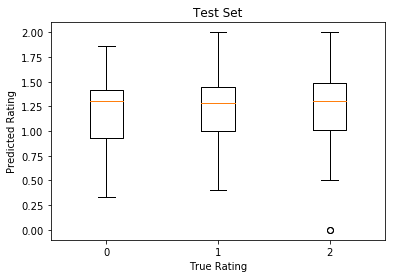

In [14]:
MakeBoxplot(Y_pred, Y, R_test, 'Test Set')

## Matrix Factorization ##
The cost function for a matrix factorization-based algorithm can be easily computed using a vectorized implementation. For the mathematical detail, you can refer to [Andrew Ng's ML course](http://www.holehouse.org/mlclass/16_Recommender_Systems.html). If the weights of a consumer is a vector $\theta$, and the features of a restaurant is a vector $x$, the predicted rating for this consumer-restaurant pair equals $\theta^{T} x$. If a bias term $b$ is used, the predicted rating is $\theta^{T} x+b$. Another way to use the bias term is to include it in $\theta$, such that $\theta_0 = b$, and add a 1 into $x$, such that $x_0 = 1$. Using this notation, the predicted rating is again $\theta^{T} x$, which is what I use here. In the following, I will use a matrix, **X**,  to express the stack of all the $x$ vectors of the restaurants, a matrix, **Theta**, to express the stack of all the $\theta$ vectors of the consumers, and a constant, **lambd**, for the L2 regularization.

In [15]:
"""
The parameters of the cost function are the features of the restaurants, with a 
shape = (n_res, n_feature), as wel as the weights of the users, with a shape = 
(n_user, n_feature+1), where the "+1" is for the bias term. However, to feed the 
cost function to SciPy's minimize(), the parameters of the function cannot be a 
matrix and has to be a 1D vector
"""
def CostFunction(params, Y, R, lambd):

    num_res = R.shape[0]  # number of restaurants
    num_user = R.shape[1] # number of users
    num_feature = (len(params)-num_res)/(num_res+num_user) # number of features

    # reshape the parameters to 2D matrices so we can perform matrix multiplication
    # X: the features of the restaurants; Theta: the weights of the users
    X = params[:num_res*num_feature].reshape(num_res, num_feature)
    X = np.append(np.ones((num_res,1)),X,axis=1) # add the bias term
    Theta = params[num_res*num_feature:].reshape(num_user, num_feature + 1)

    J = 0.5 * np.sum( (np.dot(X, Theta.T) * R - Y)**2 )

    # regularization; the bias term is not included 
    J = J + lambd/2. * ( np.sum(Theta[:,1:]**2) + np.sum(X[:,1:]**2) )

    return J

# compute the gradients of the parameters
def Gradient(params, Y, R, lambd):

    num_res = R.shape[0]    
    num_user = R.shape[1]
    num_feature = (len(params)-num_res)/(num_res+num_user)

    X = params[:num_res*num_feature].reshape(num_res, num_feature)
    X = np.append(np.ones((num_res,1)),X,axis=1) # add the bias term
    Theta = params[num_res*num_feature:].reshape(num_user, num_feature + 1)

    X_grad = np.dot((np.dot(X, Theta.T) * R - Y), Theta)
    Theta_grad = np.dot((np.dot(Theta, X.T) * R.T - Y.T), X)

    X_grad = X_grad + lambd * X
    X_grad = X_grad[:,1:]
    Theta_grad[:,1:] = Theta_grad[:,1:] + lambd*Theta[:,1:]

    grad = np.append(X_grad.reshape(-1), Theta_grad.reshape(-1))
    
    return grad

Secondly, we need to perform "mean normalization" on the ratings. For each restaurant, we will subtract the average rating from all the ratings (in the training set). So after the normalization, the average rating is 0 for all the restaurant. The model will be trained on these normalized ratings instead of the original values. When we make the prediction, we will add those average ratings back.
<br><br>
According to Andrew Ng's course, the reason for doing this is that if there is a user who never rated anything (so there is no data we can learn from this user), the predicted ratings for him/her will be the average values. In this dataset, all the users have rated some restaurants. However, performing mean normalization is still preferred as it scales the predicted ratings to roughly the right scale. What the model learns and predicts is therefore the **deviation** from the average rating (as a function of users) instead of the absolute value of a rating. The average rating of each restaurant is essentially a base value of the prediction. If mean normalization is not performed, the model would perform poorly.

In [16]:
def MeanNorm(Y,R):
    
    Y_norm = Y*R
    mean =  (np.sum(Y_norm, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    Y_norm = (Y_norm - mean)*R

    return Y_norm, mean

In [17]:
np.random.seed(0)

# The hyperparameters we can tune are the number of features and the L2 regularization
# One can use grid search or random search to find the best combination. The following 
# values are what I found that lead to the best FCP
n_feature = 3
lambd = 0.5

# initialize the parameters
X = np.random.normal(0,1,(n_res, n_feature)) # the features of the restaurants 
Theta = np.random.normal(0,1,(n_user, n_feature + 1)) # the weights of the users

# unroll them to a 1D vector
initial_parameters = np.append(X.reshape(-1), Theta.reshape(-1)) 

# mean normalization
Y_norm, Y_mean = MeanNorm(Y,R_train)

# optimization
result = minimize(CostFunction, initial_parameters, jac=Gradient, args=(Y_norm, R_train, lambd),
                  options={'disp': True, 'maxiter': 500})

Optimization terminated successfully.
         Current function value: 48.590827
         Iterations: 391
         Function evaluations: 394
         Gradient evaluations: 394


In [18]:
# reshape the optimial parameters to 2D matrices
X_opt = result.x[:n_res*n_feature].reshape(n_res, n_feature)
X_opt = np.append(np.ones((n_res,1)),X_opt,axis=1)
Theta_opt = result.x[n_res*n_feature:].reshape(n_user, n_feature + 1)

Y_pred = np.dot(X_opt, Theta_opt.T) + Y_mean

# RMSE
print("RMSE of the training set: {}".format(RMSE(Y,Y_pred,R_train)))
print("RMSE of the test set: {}".format(RMSE(Y,Y_pred,R_test)))

RMSE of the training set: 0.190720212418
RMSE of the test set: 0.75963511019


In [19]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Test Set:")
FCP(Y,Y_pred,R_test)

Training Set:
Total number of rating pairs: 2380
Total number of discordant pairs: 5
Total number of concordant pairs: 1050
Total number of ties: 1325
FCP: 0.995260663507


Test Set:
Total number of rating pairs: 339
Total number of discordant pairs: 47
Total number of concordant pairs: 86
Total number of ties: 206
FCP: 0.646616541353


0.6466165413533834

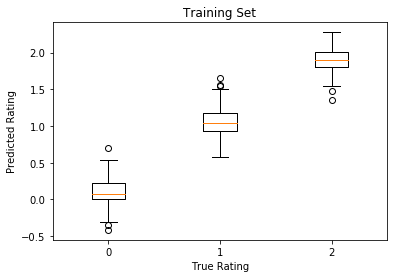

In [20]:
MakeBoxplot(Y_pred, Y, R_train, 'Training Set')

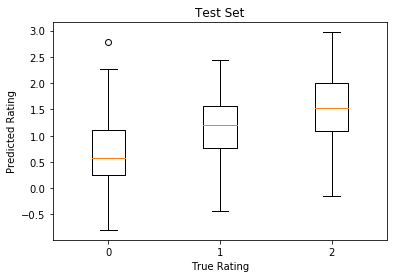

In [21]:
MakeBoxplot(Y_pred, Y, R_test, 'Test Set')

Both the RMSE and FCP are better than the benchmark model's. But we can see that the model overfits the data. If there were more data, a larger regularization might actually give a better result.

## SVD with the Surprise Package##
Surprise is an easy-to-use Python package for recommender systems. Please refer to their [project page](http://surpriselib.com/) and [document page](http://surprise.readthedocs.io/en/stable/index.html#) for details of installation and tutorials. Here I will use the famous [SVD algorithm](http://sifter.org/simon/journal/20061211.html). The document for this model in the Surprise page is [here](http://surprise.readthedocs.io/en/stable/matrix_factorization.html)

In [22]:
from surprise import SVD
from surprise.dataset import Reader, Dataset

To load a data frame or csv file, the columns must correspond to user id, item id and ratings (in this order). In order to compare the result of SVD with my models, we have to use the same train/test split that was used above and transform them to the form that can be fed to Surprise.

In [23]:
uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):

        if R_train[j,i] == 1:
            
            pID.append(placeID[j])
            uID.append(userID[i])
            r.append(Y[j,i])


rating_train = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})
rating_train = rating_train[['userID','placeID','rating']]

uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):

        if R_test[j,i] == 1:
            
            pID.append(placeID[j])
            uID.append(userID[i])
            r.append(Y[j,i])


rating_test = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})
rating_test = rating_test[['userID','placeID','rating']]

In [24]:
# A reader is needed to specify the rating_scale
reader = Reader(rating_scale=(0, 2))
data_train = Dataset.load_from_df(rating_train, reader)
trainset = data_train.build_full_trainset() # use the whole training set 

In [25]:
# I'll randomly sample three hyperparameters (n_factors, lr_all, reg_all) in 1000 
# iterations, searching for the result with the best FCP of the test set
FCP_test_best = 0
Y_pred_best = 0
n_factors_best = 0
lr_all_best = 0
reg_all_best = 0

size_test = len(rating_test)
size_train = len(rating_train)
r_pred_test = np.zeros(size_test)
r_pred_train = np.zeros(size_train)

for i in range(1000):
    
    if (i+1)%100 == 0: print("{} iterations".format(i+1))

    n_factors = random.randint(2, 20) # 2~20
    lr_all = 0.001* 10**random.uniform(0, 1) # 0.001~0.01
    reg_all = 0.05* 100**random.uniform(0, 1) # 0.05~5

    model = SVD(n_factors=n_factors, lr_all=lr_all, reg_all=reg_all)
    model.train(trainset)

    # my data form of ratings: shape=(130,138)
    Y_pred = pd.DataFrame( np.zeros((n_res,n_user))-1.0, columns=userID, index=placeID )

    # obtain predictions for the test set
    for i in range(size_test):
        pred = model.predict(rating_test.userID[i], rating_test.placeID[i], verbose=False)
        r_pred_test[i] = pred.est
    # fill the predictions into my 'Y_pred' data frame
    for p, u, r in zip(rating_test.placeID, rating_test.userID, r_pred_test):
        Y_pred.loc[p,u] = r

    # obtain predictions for the training set  
    for i in range(size_train):
        pred = model.predict(rating_train.userID[i], rating_train.placeID[i], verbose=False)
        r_pred_train[i] = pred.est
    # fill the predictions into my 'Y_pred' data frame  
    for p, u, r in zip(rating_train.placeID, rating_train.userID, r_pred_train):
        Y_pred.loc[p,u] = r

    Y_pred = Y_pred.values    
    FCP_test = FCP(Y,Y_pred,R_test,verbose=False)

    if FCP_test > FCP_test_best:

        FCP_test_best = FCP_test
        Y_pred_best = Y_pred
        n_factors_best = n_factors
        lr_all_best = lr_all
        reg_all_best = reg_all

print("\nbest FCP: {}".format(FCP_test_best))
print("n_factors: {}".format(n_factors_best)) 
print("lr_all: {}".format(lr_all_best))
print("reg_all: {}".format(reg_all_best))  

100 iterations
200 iterations
300 iterations
400 iterations
500 iterations
600 iterations
700 iterations
800 iterations
900 iterations
1000 iterations

best FCP: 0.616541353383
n_factors: 19
lr_all: 0.00647738136102
reg_all: 0.16396498067


In [26]:
# RMSE
print("RMSE of the training set: {}".format(RMSE(Y,Y_pred_best,R_train)))
print("RMSE of the test set: {}".format(RMSE(Y,Y_pred_best,R_test)))

RMSE of the training set: 0.545213206303
RMSE of the test set: 0.635869855006


In [27]:
# FCP
print("Training Set:")
FCP(Y,Y_pred_best,R_train)
print("\n")
print("Test Set:")
FCP(Y,Y_pred_best,R_test)

Training Set:
Total number of rating pairs: 2380
Total number of discordant pairs: 252
Total number of concordant pairs: 803
Total number of ties: 1325
FCP: 0.761137440758


Test Set:
Total number of rating pairs: 339
Total number of discordant pairs: 51
Total number of concordant pairs: 82
Total number of ties: 206
FCP: 0.616541353383


0.6165413533834586

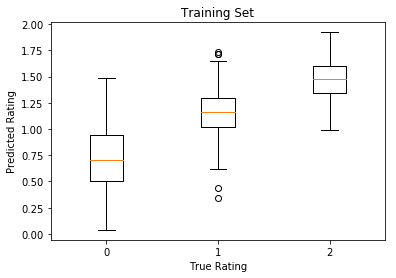

In [28]:
MakeBoxplot(Y_pred_best, Y, R_train, 'Training Set')

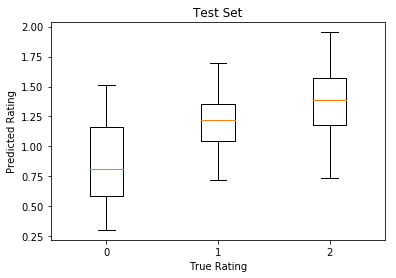

In [29]:
MakeBoxplot(Y_pred_best, Y, R_test, 'Test Set')

The SVD model results in a better RMSE on the test set, but has a worse FCP. This illustrates that RMSE can be a bad evaluation metric for recommender systems.